# Statistical Methods in Image Processing EE-048954
## Homework 2: Langevin Dynamics and Energy-Based Models
### Due Date: <span style="color:red">May 31, 2022</span>

###  Submission Guidelines

* Submission only in **pairs** on the course website (Moodle).
* Working environment:
    * We encourage you to work in `Jupyter Notebook` online using <a href="https://colab.research.google.com/">Google Colab</a> as it does not require any installation.
* You should submit two **separated** files:
    * A `.ipynb` file, with the name: `ee048954_hw2_id1_id2.ipynb` which contains your code implementations.
    * A `.pdf` file, with the name: `ee048954_hw2_id1_id2.pdf` which is your report containing plots, answers, and discussions.
    * **No handwritten submissions** and no other file-types (`.docx`, `.html`, ...) will be accepted.

### Mounting your drive for saving/loading stuff

In [111]:
#from google.colab import drive
#drive.mount('/content/drive')

### Importing relevant libraries for Part I

In [34]:
## Standard libraries
import os
import math
import torch
import time
import numpy as np
import random
import copy

## Scikit-learn built-in dataset generator
from sklearn.datasets import make_blobs

## Progress bar
import tqdm

## Imports for plotting
import matplotlib.pyplot as plt

import matplotlib.animation as animation
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')
image_size = 28
import torch.distributions.uniform as uniform
import torch.distributions.multivariate_normal as normal
import seaborn as sns
import datetime
def set_visualization_settings():
    FIGURE_DPI = 300
    SAVEFIG_DPI = 96
    SMALL_FONT_SIZE = 14
    MEDIUM_FONT_SIZE = 16
    BIG_FONT_SIZE = 18
    TITLE_FONT_SIZE = 18
    SUPTITLE_FONT_SIZE = 22
    COLORS = ["darkblue", "darkgreen", "darkred"]
    plt.rcParams['figure.dpi'] = FIGURE_DPI
    plt.rcParams['savefig.dpi'] = SAVEFIG_DPI


    # Create an array with the colors to use
    # Set a custom color palette
    sns.set_palette(sns.color_palette(COLORS))

    plt.rc('font', size=SMALL_FONT_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=TITLE_FONT_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=BIG_FONT_SIZE)  # fontsize of the x and y labels
    plt.rc('axes', labelweight='bold')  # weight of the x and y labels
    plt.rc('xtick', labelsize=SMALL_FONT_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_FONT_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_FONT_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=SUPTITLE_FONT_SIZE)  # fontsize of the figure title
    # plt.rc('text', usetex=True)
    plt.rc('font', weight='bold')
    plt.rcParams['text.latex.preamble'] = r'\boldmath'


def stitle2figname(stitle: str, format_fig='png'):
    # Replace chars that are not acceptable to file names
    title_str = stitle.replace("\n", "").replace("  ", " ").replace("__", "_"). \
        replace("\\", "_").replace("/", "_").replace(":", '-').replace('.', '_').replace('$', '')
    fig_name = f"{title_str}.{format_fig}"
    return fig_name


set_visualization_settings()

def save_fig(fig, fig_name: str = '',
             folder_name: os.path = os.path.join(os.path.curdir, 'figures'),
             format_fig='png', dpi: int = 100):
    if fig_name == '':
        fig_name = f"figure_{datetime.now().strftime('%Y_%m_%d %H_%M')}"
    fname = stitle2figname(fig_name, format_fig)
    if not os.path.exists(folder_name):
        try:
            os.makedirs(folder_name, exist_ok=True)
            print(f"Creating folder: {folder_name}")
        except Exception:
            raise OSError(f"Failed to create folder: {folder_name}")
    fpath = os.path.join(folder_name, fname)
    fig.savefig(fpath, bbox_inches='tight', format=format_fig.replace('.', ''), dpi=dpi)
    print(f"Figure saved at {fpath}")
    return fpath


figs_folder = r'C:\Users\addalin\Dropbox\Apps\Overleaf\Statistical_image_processing\HW2\figures'

## Part I: Toy 2D Dataset (10 points)

In this homework we will look into stochastic sampling techniques that could be used to sample from energy-based models of images. But, to kick things off, we will first start with the simple toy 2D dataset comprised of 5 rotated and equally-spaced Gaussian Mixture distribution we are familiar with from HW1 with slight adjustments: 

<center width="100%"><img src="https://drive.google.com/uc?id=1DUVGzms8W_u7HrVyFb1QSxeszY9cs8Nr" width="800px"></center>

More formally, the probability density distribution considered is given by:

  $$p(x;\sigma,\{\mu_i\}) = \frac{1}{M} \sum_{m=1}^{M} \frac{1}{2\pi\sigma^2} \exp\left\{-\frac{1}{2\sigma^2}||x-\mu_i||^2\right\} ,$$
   with $M = 5$, $\sigma^2 = 0.1$, 
   
   and $\{\mu_m\} = 0.7 \cdot \{(1,0)^T , (\cos(\frac{2\pi}{5}),\sin(\frac{2\pi}{5}))^T , (\cos(\frac{4\pi}{5}),\sin(\frac{4\pi}{5}))^T , (\cos(\frac{6\pi}{5}),\sin(\frac{6\pi}{5}))^T , (\cos(\frac{8\pi}{5}),\sin(\frac{8\pi}{5}))^T\}$.
  
<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 1</span>**. Write down the analytical gradient of $\log p(x)$ with respect to $x$. i.e. $\nabla_x \log p(x)$.

While this distribution can be sampeld trivially using standard techniques, here we will sample from it using Langevin Dynamics. 

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 2</span>**. Implement Langevin Dynamics for sampling from $p(x)$:
* Initialize 1000 random 2D points $x$ i.i.d distributed according to $U[-3.0,3.0]$.

* Update the points according to the Langevin Dynamics update step:
$$x^{k+1} = x^k + \varepsilon \nabla \log p(x^k) + \sqrt{2\varepsilon}N^k.$$
Use $\sqrt{2\varepsilon}=\frac{10}{256}$ and $N \sim \mathcal{N}(0,I)$.

* Repeat the previous step for $K=5000$ iterations.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 3</span>**. Draw $N = 1000$ samples ${x_i}$ from $p(x)$ using the provided code lines below and compare them visually to the samples drawn using Langevin Dynamics. Present both sample types and discuss the results.

In [2]:
#Task 2

#check all dims of x and mu and all intermediate computations
def log_prob_grad(x,mus,sigma_2):
    sum_num = 0
    sum_denom = 0
    for mu in mus:
        exp_arg = torch.exp((2*sigma_2)*(-1)*torch.norm(x-mu,dim=1)**2)
        sum_num += ((x-mu).T* exp_arg)
        sum_denom +=exp_arg
        
    grad = (sigma_2)*(-1)*sum_num/sum_denom
    #exp_arg = torch.exp((2*sigma_2)*(-1)*torch.norm(x-mus,dim=2)*2)
    #numerator = (sigma_2)*(-1)*torch.sum(exp_arg(x-mus)) # two sums to emphasize that first sum is 
                                                                            # for row by row multiplication 
                                                                            # and the second sum is the original sum from the w.

    #denominator = torch.sum(exp_arg,dim=1)
    #grad = numerator/denominator
    return grad

#TODO : take out the parameters
def sample_with_langevin_dynamics(N, sqrt_two_eps,init_samples=None):
    norm = normal.MultivariateNormal(torch.tensor([0.,0.]),torch.eye(2))
    # if we want to start from new samples
    if init_samples == None:
        uni = uniform.Uniform(torch.tensor([-3.,-3.]),torch.tensor([3.,3.]))
        init_samples = uni.sample((N,))

    # define p(x):
    sigma_2 = 0.1
    arg = torch.tensor([0,2,4,6,8])
    mus = []
    for i in arg:
        mu_i = torch.tensor([torch.cos(i*torch.pi/5),torch.sin(i*torch.pi/5)]).T
        mus.append(mu_i)
    mus = torch.vstack(mus)

    K=5000
    x_k = init_samples
    _all_x = [] # for debug
    for k in range(K):
        grad = log_prob_grad(x_k,mus,sigma_2)
        x_k = x_k + sqrt_two_eps**2/2*grad.reshape(-1,2) + sqrt_two_eps * norm.sample((N,))
        _all_x.append(x_k[0])
    
    return x_k.numpy() ,_all_x

In [3]:
num_samples, seed, = 1000 , 0
np.random.seed(seed)
angles = np.linspace(0, 2 * np.pi, 5, endpoint=False)
centers = np.stack([0.7 * np.array([np.cos(angle), np.sin(angle)]) for angle in angles])
real_samples = make_blobs(num_samples, centers=centers, cluster_std=np.sqrt(.1), random_state=seed, shuffle=True)[0]

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 4</span>**. Repeat Tasks 2 and 3, this time with $\sqrt{2\varepsilon}=\left\{\frac{1}{256}, \frac{200}{256}\right\}$. Compare the results to Task 3, and explain the effect of $\varepsilon$ on the resulting samples. Tip: To have a clear visual examination of the phenomenon, plot the path a sampled point goes through throughout the dynamics for different values of $\varepsilon$.

In [5]:
#Task 3 + 4 
#initialize samples:
sqrt_two_eps = [10/256, 1/256,200/256] # running on values from task 3 +4
N=1000
#start with same samples for easier comparison
uni = uniform.Uniform(torch.tensor([-3.,-3.]),torch.tensor([3.,3.]))
init_samples = uni.sample((N,))

all_eps_lsd = []
all_eps_lds_path = []
for ste in sqrt_two_eps:
    lds,lds_path = sample_with_langevin_dynamics(N,ste,init_samples)
    all_eps_lsd.append(lds)
    all_eps_lds_path.append(lds_path)



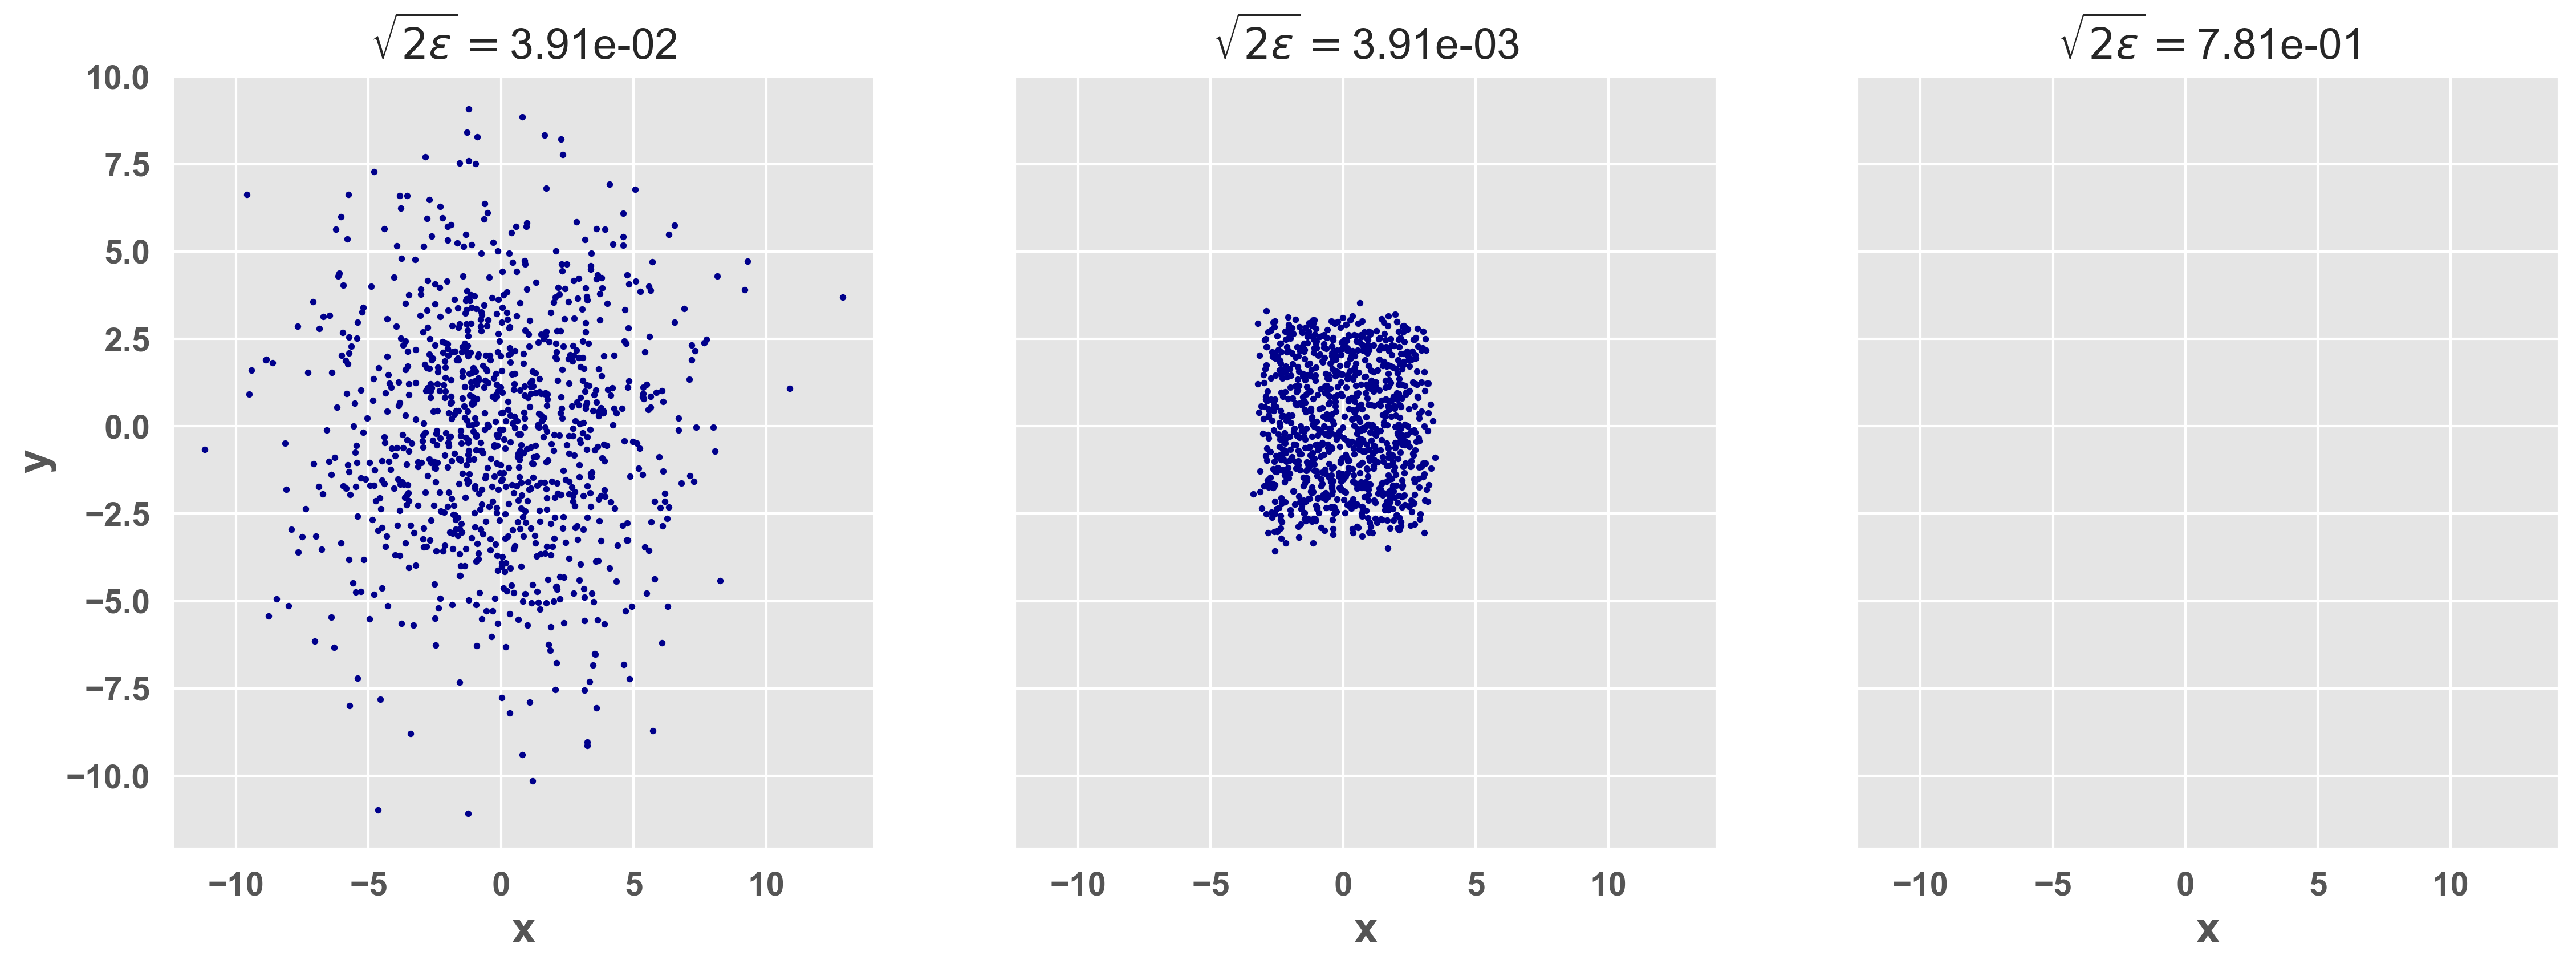

Figure saved at C:\Users\addalin\Dropbox\Apps\Overleaf\Statistical_image_processing\HW2\figures\points tasks 2-3-4.jpg


'C:\\Users\\addalin\\Dropbox\\Apps\\Overleaf\\Statistical_image_processing\\HW2\\figures\\points tasks 2-3-4.jpg'

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=len (all_eps_lsd), sharey=True, sharex=True, figsize = (18,6))
for ind,(points, ax) in enumerate(zip(all_eps_lsd, axes.ravel())):
    ax.scatter(points[:,0],points[:,1], s=5)
    ax.set_title(fr"$\sqrt{{2\epsilon}}=${sqrt_two_eps[ind]:.2e}")
    if ind==0:
        ax.set_ylabel('y')
    ax.set_xlabel('x')
plt.show()


save_fig(fig, fig_name= 'points tasks 2-3-4',
             folder_name = figs_folder,
             format_fig='jpg', dpi= 100)

C:\Users\addalin\AppData\Local\Temp\ipykernel_34388\4258838391.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar= plt.colorbar(img, ax=ax)


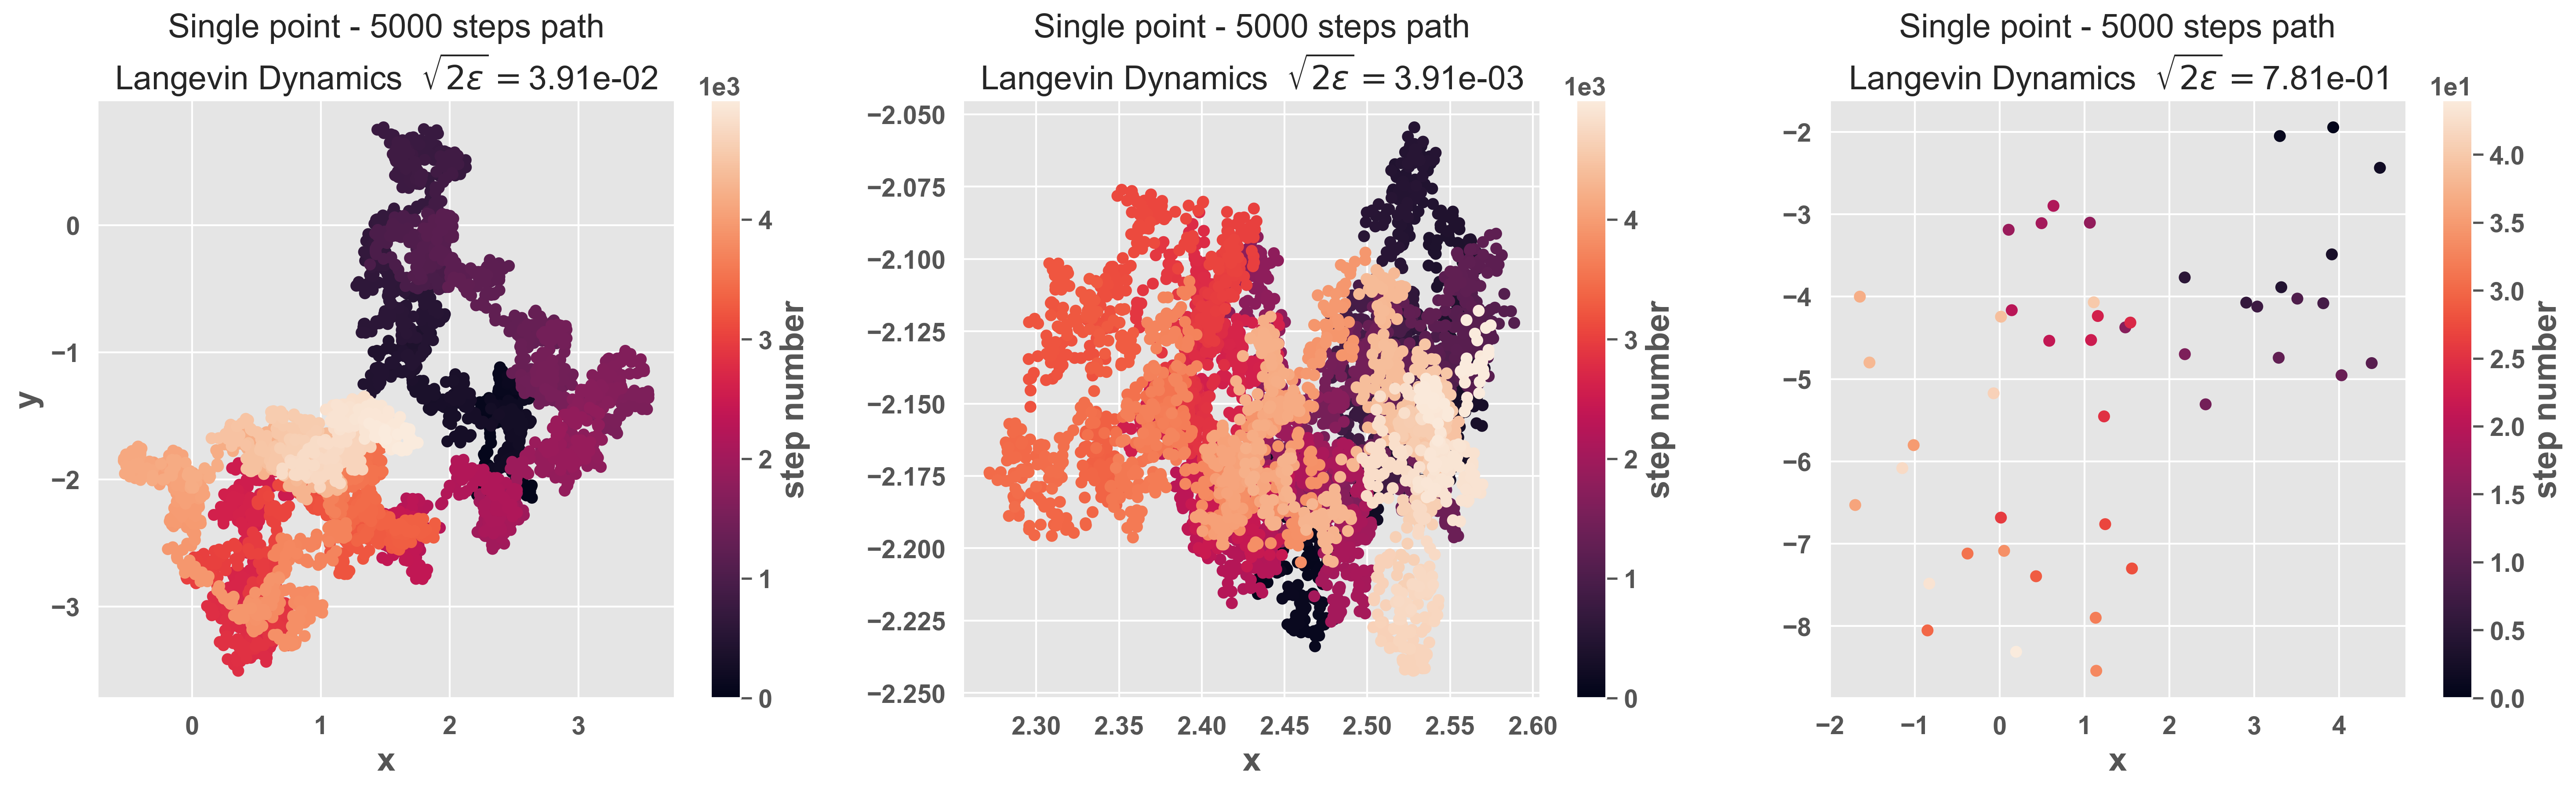

Figure saved at C:\Users\addalin\Dropbox\Apps\Overleaf\Statistical_image_processing\HW2\figures\paths tasks 2-3-4.jpg


'C:\\Users\\addalin\\Dropbox\\Apps\\Overleaf\\Statistical_image_processing\\HW2\\figures\\paths tasks 2-3-4.jpg'

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=len (all_eps_lsd), figsize = (24,6))
for ind,(path, ax) in enumerate(zip(all_eps_lds_path, axes.ravel())):
    px = [p.numpy()[0] for p in path]
    py = [p.numpy()[1] for p in path]
    col = list(range(len(px)))
    img= ax.scatter(px,py,c= col)
    cbar= plt.colorbar(img, ax=ax)
    cbar.set_label('step number')
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()

    if ind==0:
        ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.set_title("Single point - 5000 steps path\n"+fr"Langevin Dynamics  $\sqrt{{2\epsilon}}=${sqrt_two_eps[ind]:.2e}")
plt.show()


save_fig(fig, fig_name= 'paths tasks 2-3-4',
             folder_name = figs_folder,
             format_fig='jpg', dpi= 100)

### Importing additional relevant libraries for Parts II-IV

In [72]:
## Useful for creating GIFs
import imageio

## PyTorch

import torchvision

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# device to be used for Parts II-IV is preferably a GPU
# try to change the runtime type to GPU if you can in Google Colab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


## Part II: Langevin Dynamics (30 points) 

### General Introduction

In the remainder of this exercise we will focus on sampling from an Energy Based Model (EBM) that was trained to fit the distribution $p(x)$ of the [MNIST digits dataset](http://yann.lecun.com/exdb/mnist/) (no need to download the dataset). The EBM is given in the form of a Convolutional Neural Network (CNN), and defined by
$$ p_\theta(x) = \frac{1}{Z(\theta)}e^{-E_\theta(x)}.$$
Specifically, the model gets an image $x$ and returns $E_\theta(x)$, where $\theta$ are the trained model parameters. We will use this model in order to sample new digits from the MNIST distribution. In order to do so, we will use MCMC with Langevin Dynamics.

### Model Architecture

The provided class below `ResNet` implements the neural network approximating $E(x)$ with a parametric function $E_{\theta}(x)$, and is based on the architecture from the paper [wide residual networks](https://arxiv.org/abs/1605.07146). Note that for our purposes in this exercise you **don't** need to understand this class thoroughly. You can treat this network as a black-box that accepts an image $x$ as input and returns $E_{\theta}(x) \approx E(x)$ as output, and can also provide us with the gradient of $E(x)$ with respect to its input using automatic differentiation, i.e. $\nabla_x E(x)$.

In [65]:
# the next lines define the architecture of the model and its functionality in forward path 
# (e.g how it operates when inputting an image)
class ResNet(torch.nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        levels_params = [
            {'n_channels': 16, 'n_blocks': 2, 'downsample': False},
            {'n_channels': 32, 'n_blocks': 2, 'downsample': True},
            {'n_channels': 64, 'n_blocks': 2, 'downsample': True},
            {'n_channels': 64, 'n_blocks': 2, 'downsample': True},
            ]

        self._el = torch.nn.ModuleDict()

        self._el['in_conv'] = torch.nn.Conv2d(n_channels, 16, kernel_size=3, padding=3)
        n_channels = 16

        levels = torch.nn.ModuleList()
        for level_params in levels_params:
            level = torch.nn.ModuleDict()
            res_blocks = torch.nn.ModuleList()

            ## The first residual block in the level
            res_block = torch.nn.ModuleDict()
            n_channels_out = level_params['n_channels']
            if level_params['downsample']:
                res_block['shortcut_conv'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=2, stride=2)
            else:
                res_block['shortcut_conv'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=1)
            res_block['conv_1'] = torch.nn.Conv2d(n_channels, n_channels_out, kernel_size=3, padding=1)
            n_channels = n_channels_out
            if level_params['downsample']:
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=4, stride=2, padding=1)
            else:
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=1, padding=1)
            res_blocks.append(res_block)

            ## The rest of the residual blocks in the level
            for _ in range(level_params['n_blocks'] - 1):
                res_block = torch.nn.ModuleDict()
                res_block['conv_1'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
                res_block['conv_2'] = torch.nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
                res_blocks.append(res_block)
            level['res_blocks'] = res_blocks
            levels.append(level)
        self._el['levels'] = levels

        self._el['out_fc'] = torch.nn.Linear(n_channels, 1, bias=False)

        for module in self.modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.xavier_uniform_(module.weight, gain=2 ** 0.5)
                if module.bias is not None:
                    module.bias.data.zero_()

    # functionality when inputting image x to the model:
    def forward(self, x):
        x = self._el['in_conv'](x)

        for level in self._el['levels']:
            for res_block in level['res_blocks']:
                shortcut = x
                x = torch.nn.functional.leaky_relu(x, 0.2)
                x = res_block['conv_1'](x)
                x = torch.nn.functional.leaky_relu(x, 0.2)
                x = res_block['conv_2'](x)
                if 'shortcut_conv' in res_block:
                    shortcut = res_block['shortcut_conv'](shortcut)
                x = x + shortcut

        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = x.view(x.shape[0], x.shape[1], -1).sum(dim=2)
        x = self._el['out_fc'](x)

        return x[:, 0]

For your convinience, we provide pre-trained model weights $\theta^{\star}$ on the MNIST dataset, Courtesy of Mr. Omer Yair. To instantiate the model and load the pretrained weights $\theta^{\star}$ from the attached file `checkpoint.pt`, you can use the following:

In [66]:
# instantiate the class above for images with 1 channel and load it to the device (CPU/GPU)
ebm = ResNet(n_channels=1).to(device)

# transfer the model to evaluation mode (as we don't want to train it, just to use it)
ebm.eval()

# load the trained model weights/parameters from the checkpoint file
checkpoint_path = 'checkpoint.pt'
ebm.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

After loading the trained weights $\theta^{\star}$, we can feed the model with images $x$ and get their approximated energy $E_{\theta^{\star}}(x)$ by a simple forward pass:

In [67]:
# number of images to generate
n_imgs = 30

# randomly initialized 28x28x1 images with i.i.d pixels ~U[0,1]
imgs = torch.rand((n_imgs, 1, image_size, image_size), device=device)

# set the images to have a gradient graph so we could calculate the gradient of the model
imgs.requires_grad_(True)

# run the model: input the images x, getting as output their estimated energy E(x)
energy = ebm(imgs)

To calculate the gradient of the model output $E(x)$ with respect to the input images $x$, we can use automatic differentiation because we previously set the `requires_grad_` property of the input images to `True`:

In [68]:
# calculates the gradient of the model: grad(E(x)) with respect to x.
grad = torch.autograd.grad(energy.sum(), imgs)[0]

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 5</span>**. Run Langevin Dynamics for the provided EBM:
* Initialize 30 random images of size $28\times28$ distributed i.i.d according to $U[0,1]$.

* Update the images according to the Langevin Dynamics update step:
$$x^{k+1} = x^k + \varepsilon \nabla \log p(x^k) + \sqrt{2\varepsilon}N^k.$$
Use $\sqrt{2\varepsilon}=\frac{2}{256}$ and $N \sim \mathcal{N}(0,I)$. Note that although we do not have an explicit expression for $p(x)$, but only for $E(x)$, we are still able to perform the update step, how? For calculating the gradient you can use automatic differentiation as described above.

* Repeat the previous step for $K=2000$ iterations. Present the final samples and discuss the results.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 6</span>**. Repeat the previous task for $K=2000$ iterations, this time with $\sqrt{2\varepsilon}=\frac{3}{256}$. Present the final samples and discuss the results comparing to the previous section.

Task 5 question:
we are able to perform the update step because if we derive p(x) by x we stay only with $\nabla_x E(x)$

In [97]:
def ld_on_ebm(n_imgs ,image_size, K,sqrt_two_eps, device):
    # randomly initialized 28x28x1 images with i.i.d pixels ~U[0,1]
    x_k = torch.rand((n_imgs, 1, image_size, image_size), device=device)
    # set the images to have a gradient graph so we could calculate the gradient of the model
    x_k.requires_grad_(True)
    norm = normal.MultivariateNormal(torch.zeros(image_size,image_size),torch.eye(image_size))
    for k in range(K):
        # run the model: input the images x, getting as output their estimated energy E(x)
        energy = ebm(x_k)
        # calculates the gradient of the model: grad(E(x)) with respect to x.
        grad = -torch.autograd.grad(energy.sum(), x_k)[0]
        samples = norm.sample((n_imgs,1)).to(device)
        x_k = x_k + sqrt_two_eps**2/2*grad + sqrt_two_eps *samples
        if (k%100 == 0):
            print('iteration {0} completed'.format(k))
        #_all_x.append(x_k[0])
    return x_k

In [105]:
def tensors_as_images(
    tensors, nrows=1, figsize=(20, 2), titles=[], wspace=0.1, hspace=0.2, cmap=None
):
    """
    Plots a sequence of pytorch tensors as images.
    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize,
        gridspec_kw=dict(wspace=wspace, hspace=hspace),
        subplot_kw=dict(yticks=[], xticks=[]),
    )
    if type(axes) is np.ndarray:
        axes_flat = axes.reshape(-1)
    else:
        axes_flat =np.array(axes)
        axes_flat = axes_flat.reshape(-1)

        
    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.to('cpu').numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image - min) / (max - min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis("off")

    return fig, axes


In [101]:
# Task 5
eps_size = torch.tensor(2/256, device=device)
x_k = ld_on_ebm(n_imgs=n_imgs, image_size=image_size,
                K=2000,sqrt_two_eps=eps_size, device=device)
x_k = x_k.detach()


iteration 0 completed
iteration 100 completed
iteration 200 completed
iteration 300 completed
iteration 400 completed
iteration 500 completed
iteration 600 completed
iteration 700 completed
iteration 800 completed
iteration 900 completed
iteration 1000 completed
iteration 1100 completed
iteration 1200 completed
iteration 1300 completed
iteration 1400 completed
iteration 1500 completed
iteration 1600 completed
iteration 1700 completed
iteration 1800 completed
iteration 1900 completed


Figure saved at C:\Users\addalin\Dropbox\Apps\Overleaf\Statistical_image_processing\HW2\figures\task5.jpg


'C:\\Users\\addalin\\Dropbox\\Apps\\Overleaf\\Statistical_image_processing\\HW2\\figures\\task5.jpg'

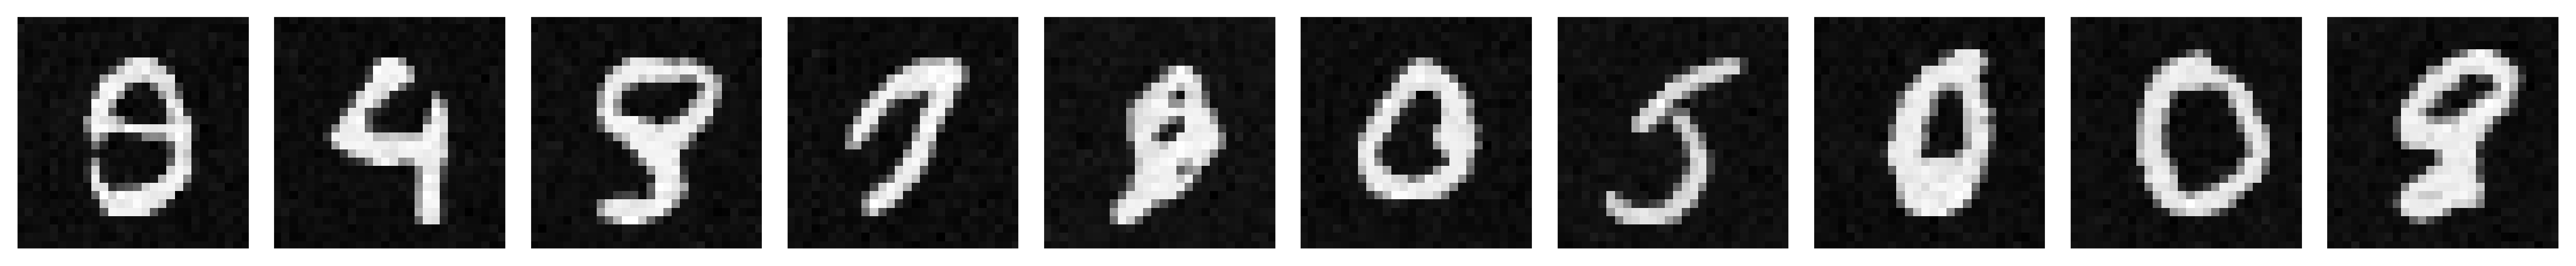

In [109]:
fig, ax = tensors_as_images(x_k[0:10],cmap='gray', figsize=(20, 2))
save_fig(fig, fig_name= 'task5',
             folder_name = figs_folder,
             format_fig='jpg', dpi= 100)

In [112]:
#Task 6
eps_size = torch.tensor(10/256, device=device)
x_k = ld_on_ebm(n_imgs=n_imgs, image_size=image_size,
                K=2000,sqrt_two_eps=eps_size, device=device)
x_k = x_k.detach()


iteration 0 completed
iteration 100 completed
iteration 200 completed
iteration 300 completed
iteration 400 completed
iteration 500 completed
iteration 600 completed
iteration 700 completed
iteration 800 completed
iteration 900 completed
iteration 1000 completed
iteration 1100 completed
iteration 1200 completed
iteration 1300 completed
iteration 1400 completed
iteration 1500 completed
iteration 1600 completed
iteration 1700 completed
iteration 1800 completed
iteration 1900 completed


Figure saved at C:\Users\addalin\Dropbox\Apps\Overleaf\Statistical_image_processing\HW2\figures\task6.jpg


'C:\\Users\\addalin\\Dropbox\\Apps\\Overleaf\\Statistical_image_processing\\HW2\\figures\\task6.jpg'

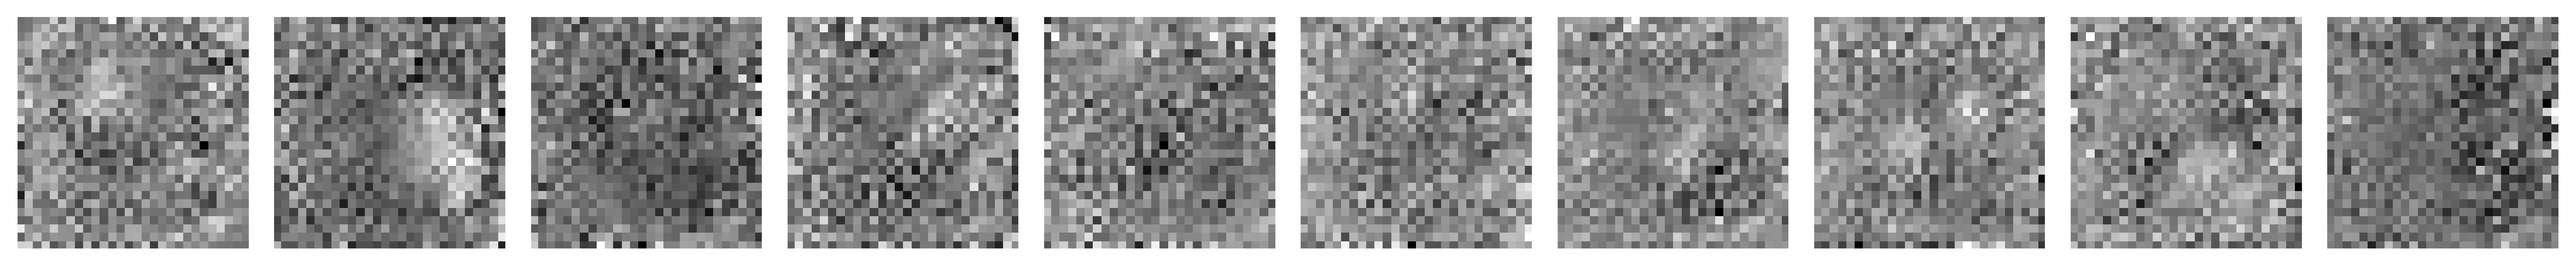

In [113]:
fig, ax = tensors_as_images(x_k[0:10],cmap='gray', figsize=(20, 2))
save_fig(fig, fig_name= 'task6',
             folder_name = figs_folder,
             format_fig='jpg', dpi= 100)

## Part III: MALA (30 points) 

We will now expand Part II into the Metropolis-Adjusted Langevin Algorithm (MALA):

* Use the same initialization scheme as in Langevin Dynamics
* use the same update step as before
$$x^{k+1} = x^k + \varepsilon \nabla \log p(x^k) + \sqrt{2\varepsilon}N^k,$$
    with $\sqrt{2\varepsilon}=\frac{2}{256}$ and $N \sim \mathcal{N}(0,I)$.
* **Acceptance step**: accept the sample $x^{k+1}$ according to the acceptance rule:
    * If $x^{k+1}$ is more probable than $x^k$ then accept $x^{k+1}$
    * else, replace $x^{k+1}$ with $x^k$ with probability $\alpha$, where
    $$\alpha \triangleq \frac{p(x^{k + 1}) q(x^k \mid x^{k+1})}{p(x^k) q(x^{k+1}\mid x^k)}$$
    and
    $$q(x'\mid x) \propto \exp \left( - \frac{1}{4 \varepsilon} \| x' - x - \varepsilon \nabla \log p(x) \|_2^2 \right).$$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 7</span>**. In the acceptance step of the MALA algorithm we can use $E(x)$ without explicitly knowing $p(x)$. Why?

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 8</span>**. Apply the MALA algorithm for $K=2000$ iterations. Present the final samples and discuss the results. 

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 9</span>**. Apply the MALA algorithm for $K=2000$ iterations, with $\sqrt{2\varepsilon}=\frac{3}{256}$. Present the final samples and discuss the results.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 10</span>**. Apply the MALA algorithm for $K=20,000$ iterations (it might take a few minutes), with $\sqrt{2\varepsilon}=\frac{3}{256}$. **Instead of random initialization**, run Langevin dynamics as in Part II with $\sqrt{2\varepsilon}=\frac{2}{256}$ for $K=500$ iterations and use these images as your initialization for the MALA algorithm. Present the final samples and examples for samples in intermediate iterations. Discuss the results.

In [166]:
# task 8
def q_x_prime_given_x(x_prime,x,grad_log_x,eps):
    q = torch.exp(-1/(4*eps)*torch.norm(x_prime-x-eps*grad_log_x)**2)
    return q

    
def MALA_update(x_k,p_x_k,grad_x_k,eps,sqrt_two_eps,
                image_size, n_imgs, device):
    ### Check acceptance criteria:
    norm = normal.MultivariateNormal(torch.zeros(image_size,image_size),torch.eye(image_size))
    samples = norm.sample((n_imgs,1)).to(device)
    x_k_plus_1 = x_k + ((sqrt_two_eps**2)/2)*grad_x_k + sqrt_two_eps * samples
    p_x_k_plus_1 = ebm(x_k_plus_1)
    grad_x_k_plus_1 = torch.autograd.grad(p_x_k_plus_1.sum(), x_k_plus_1)[0]

    is_accepted = p_x_k_plus_1>p_x_k
    only_accepted_x_k_plus_1 = x_k_plus_1[is_accepted]
    not_accepted_x_k_plus_1 = x_k_plus_1[~is_accepted]
    
    ### replace x_k_plus_1 with x_k with probability alpha:
    if len(not_accepted_x_k_plus_1)>0:
        q_x_k_given_x_k_plus_1 = q_x_prime_given_x(x_k,x_k_plus_1,grad_x_k_plus_1,eps)
        q_x_k_plus_1_given_x_k = q_x_prime_given_x(x_k_plus_1,x_k,grad_x_k,eps)
        alpha = p_x_k_plus_1*q_x_k_given_x_k_plus_1/(p_x_k*q_x_k_plus_1_given_x_k)

        alpha_not_accepted = alpha[~is_accepted]
        u = torch.rand(len(not_accepted_x_k_plus_1)).to(device)
        is_accepted_after_MALA = u<=alpha_not_accepted
        accepted_after_MALA_x_k_plus_1 = not_accepted_x_k_plus_1[is_accepted_after_MALA]
        x_k_remain_after_MALA = (x_k[~is_accepted])[~is_accepted_after_MALA]
        #print(len(accepted_after_MALA_x_k_plus_1) ,' were accepted after MALA')
        #not_accepted_after_MALA = not_accepted[~is_accepted_after_MALA]
        x_k_plus_1_final = torch.concat((only_accepted_x_k_plus_1,accepted_after_MALA_x_k_plus_1,x_k_remain_after_MALA))
    else:
        #print('all accepted')
        x_k_plus_1_final = only_accepted_x_k_plus_1 # all samples got updated.
        
    return x_k_plus_1_final

                                       
# number of images to generate
def ld_with_MALA(K,sqrt_two_eps,x_k,image_size, n_imgs, device):
    # set the images to have a gradient graph so we could calculate the gradient of the model
    x_k.requires_grad_(True)

    eps = (sqrt_two_eps**2)/2
    # norm = normal.MultivariateNormal(torch.zeros(image_size,image_size),torch.eye(image_size))

    #init process:
    p_x_k = ebm(x_k)
    grad_x_k = - torch.autograd.grad(p_x_k.sum(), x_k)[0]

    for k in range(K):
        # run the model: input the images x, getting as output their estimated energy E(x)
        x_k= MALA_update(x_k=x_k,p_x_k=p_x_k,
                         grad_x_k=grad_x_k,eps=eps,
                         sqrt_two_eps=sqrt_two_eps,
                         image_size = image_size, n_imgs = n_imgs,device=device)
        p_x_k = ebm(x_k)
        grad_x_k = -torch.autograd.grad(p_x_k.sum(), x_k)[0]

        if (k%200 == 0):
           print('iteration {0} completed'.format(k))
        #_all_x.append(x_k[0])
    return x_k


In [174]:
#Task 8 
# randomly initialized 28x28x1 images with i.i.d pixels ~U[0,1]
imgs = torch.rand((n_imgs, 1, image_size, image_size), device=device)
K=2000
sqrt_two_eps=2/256
eps_size = torch.tensor(data = sqrt_two_eps, device=device)
x_k = ld_with_MALA(K=K,sqrt_two_eps= eps_size,x_k=imgs,
                   image_size=image_size, n_imgs=n_imgs,device=device)

iteration 0 completed
iteration 200 completed
iteration 400 completed
iteration 600 completed
iteration 800 completed
iteration 1000 completed
iteration 1200 completed
iteration 1400 completed
iteration 1600 completed
iteration 1800 completed


Figure saved at C:\Users\addalin\Dropbox\Apps\Overleaf\Statistical_image_processing\HW2\figures\task8.jpg


'C:\\Users\\addalin\\Dropbox\\Apps\\Overleaf\\Statistical_image_processing\\HW2\\figures\\task8.jpg'

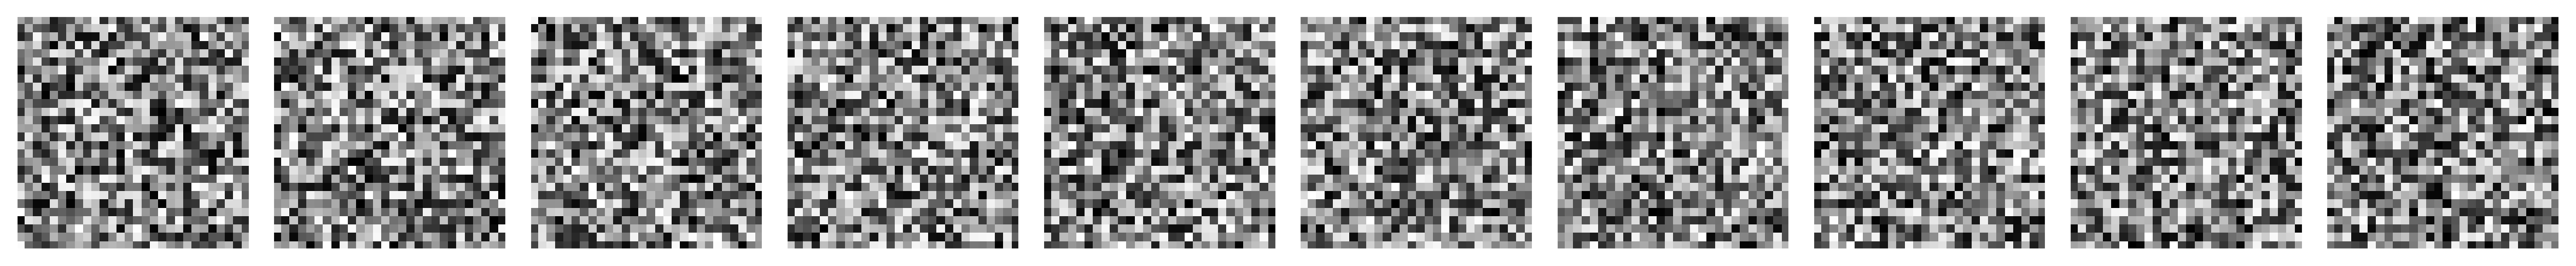

In [175]:
x_k = x_k.detach()
fig, ax = tensors_as_images(x_k[0:10],cmap='gray', figsize=(20, 2))
save_fig(fig, fig_name= 'task8',
             folder_name = figs_folder,
             format_fig='jpg', dpi= 100)

In [178]:
#Task 9
# randomly initialized 28x28x1 images with i.i.d pixels ~U[0,1]
imgs = torch.rand((n_imgs, 1, image_size, image_size), device=device)
K=2000
sqrt_two_eps=3/256
eps_size = torch.tensor(data = sqrt_two_eps, device=device)
x_k = ld_with_MALA(K=K,sqrt_two_eps= eps_size,x_k=imgs,
                   image_size=image_size, n_imgs=n_imgs,device=device)

iteration 0 completed
iteration 200 completed
iteration 400 completed
iteration 600 completed
iteration 800 completed
iteration 1000 completed
iteration 1200 completed
iteration 1400 completed
iteration 1600 completed
iteration 1800 completed
iteration 2000 completed
iteration 2200 completed
iteration 2400 completed
iteration 2600 completed
iteration 2800 completed
iteration 3000 completed
iteration 3200 completed
iteration 3400 completed
iteration 3600 completed
iteration 3800 completed
iteration 4000 completed
iteration 4200 completed
iteration 4400 completed
iteration 4600 completed
iteration 4800 completed
iteration 5000 completed
iteration 5200 completed
iteration 5400 completed
iteration 5600 completed
iteration 5800 completed
iteration 6000 completed
iteration 6200 completed
iteration 6400 completed
iteration 6600 completed
iteration 6800 completed
iteration 7000 completed
iteration 7200 completed
iteration 7400 completed
iteration 7600 completed
iteration 7800 completed
iterati

Figure saved at C:\Users\addalin\Dropbox\Apps\Overleaf\Statistical_image_processing\HW2\figures\task9.jpg


'C:\\Users\\addalin\\Dropbox\\Apps\\Overleaf\\Statistical_image_processing\\HW2\\figures\\task9.jpg'

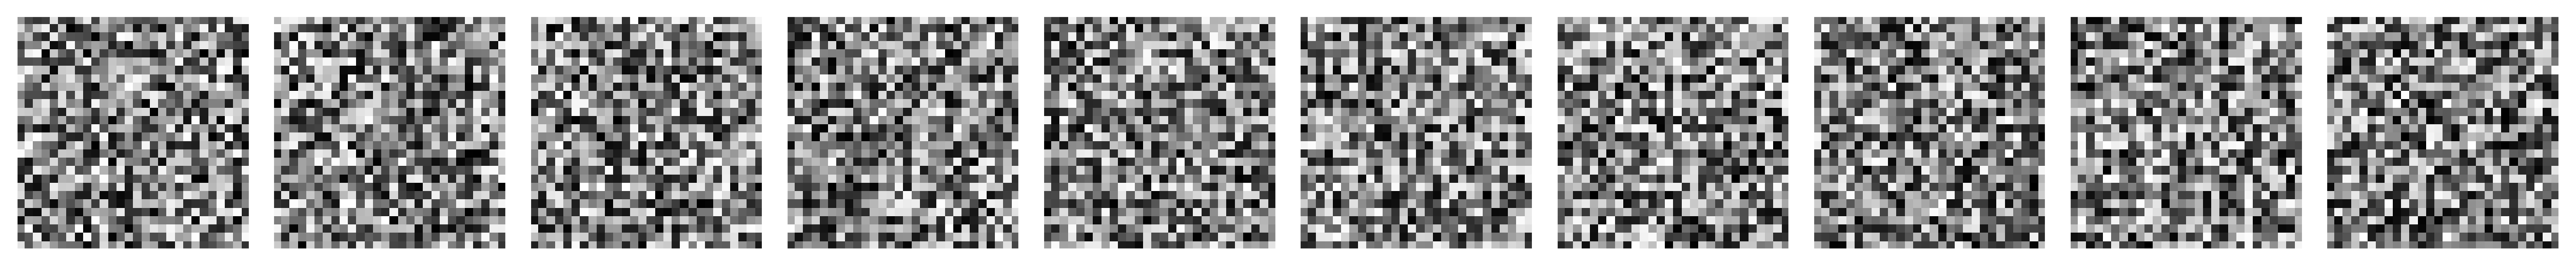

In [179]:
x_k = x_k.detach()
fig, ax = tensors_as_images(x_k[0:10],cmap='gray', figsize=(20, 2))
save_fig(fig, fig_name= 'task9',
             folder_name = figs_folder,
             format_fig='jpg', dpi= 100)

In [171]:
#Task 10
K=500
sqrt_two_eps=2/256
eps_size = torch.tensor(data = sqrt_two_eps, device=device)
imgs = ld_on_ebm(K=K,n_imgs=n_imgs,image_size=image_size, sqrt_two_eps=eps_size, device=device)


iteration 0 completed
iteration 100 completed
iteration 200 completed
iteration 300 completed
iteration 400 completed


In [172]:
K=20000
sqrt_two_eps=3/256
eps_size = torch.tensor(data = sqrt_two_eps, device=device)
x_k = ld_with_MALA(K=K,sqrt_two_eps= eps_size,x_k=imgs,
                   image_size=image_size, n_imgs=n_imgs,device=device)


iteration 0 completed
iteration 200 completed
iteration 400 completed
iteration 600 completed
iteration 800 completed
iteration 1000 completed
iteration 1200 completed
iteration 1400 completed
iteration 1600 completed
iteration 1800 completed
iteration 2000 completed
iteration 2200 completed
iteration 2400 completed
iteration 2600 completed
iteration 2800 completed
iteration 3000 completed
iteration 3200 completed
iteration 3400 completed
iteration 3600 completed
iteration 3800 completed
iteration 4000 completed
iteration 4200 completed
iteration 4400 completed
iteration 4600 completed
iteration 4800 completed
iteration 5000 completed
iteration 5200 completed
iteration 5400 completed
iteration 5600 completed
iteration 5800 completed
iteration 6000 completed
iteration 6200 completed
iteration 6400 completed
iteration 6600 completed
iteration 6800 completed
iteration 7000 completed
iteration 7200 completed
iteration 7400 completed
iteration 7600 completed
iteration 7800 completed
iterati

Figure saved at C:\Users\addalin\Dropbox\Apps\Overleaf\Statistical_image_processing\HW2\figures\task10.jpg


'C:\\Users\\addalin\\Dropbox\\Apps\\Overleaf\\Statistical_image_processing\\HW2\\figures\\task10.jpg'

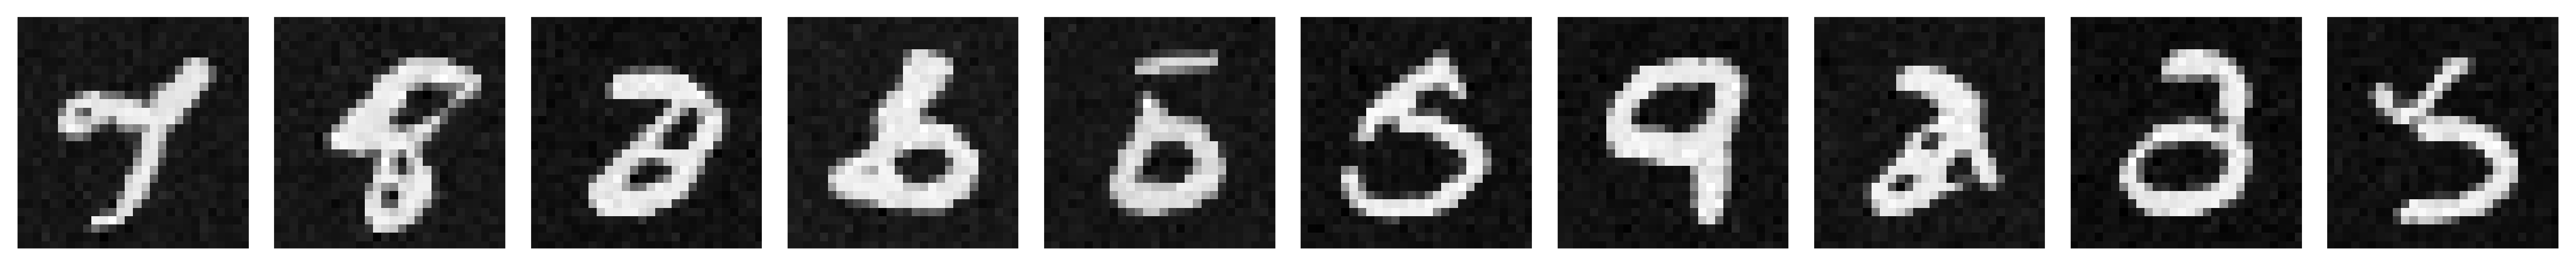

In [173]:
x_k = x_k.detach()
fig, ax = tensors_as_images(x_k[0:10],cmap='gray', figsize=(20, 2))
save_fig(fig, fig_name= 'task10',
             folder_name = figs_folder,
             format_fig='jpg', dpi= 100)

## Part IV: Perceptual and MMSE Denoising (30 points) 

Given a noisy image $y = x + n$, where $x$ is a clean image and $n \sim \mathcal{N}(0, \sigma^2I)$, we would like to estimate $x$ using Langevin Dynamics and the EBM model trained to estimate $p(x)$. We will perform denoising by drawing samples from $p(x|y)$.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 11</span>**. Write an explicit expression for $\nabla_x\log p(x|y)$ in terms of $p_x(x)$ and $p_n(n)$.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 12</span>**. How should the update step in Langevin Dynamics (Part II) be changed in order to draw samples from $p(x|y)$ instead of $p(x)$? We call such samples *perceptual* denoising results.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 13</span>**. The attachment of this exercise includes 30 noisy digits with $\sigma=\left\{\frac{50}{256},\frac{100}{256}\right\}$ (you can load the images using the command `torch.load()`). Perform perceptual denoising with Langevin Dynamics with the parameters $K=2000$ and $\sqrt{2\varepsilon}=\frac{2}{256}$. Present and discuss the results.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 14</span>**. Minimum MSE denoising can be obtained by averaging over the perceptual denoising results, since the conditional expectation $E[x|y]$ can be approximated by averaging over samples from $p(x|y)$ (namely, $E[x|y] \approx \frac{1}{N}\sum_{n=1}^N x_n$, where $\{x_n\}$ are samples from $p(x|y)$). Present the MMSE results averages over 10 perceptual samples. Why do you think the task of *perceptual denoising* is called that way?

Task 11
$$\nabla_x\log p(x|y)= \nabla_x\log  \frac{p_x(x)p(y|x)}{p(y)}  = $$
$$\nabla_x(\log p_x(x)+ \log p(y|x) - \log(p(y))) =$$
$$\nabla_x \log p_x(x)+ \nabla_x \log p(y|x) $$



for a given x , p(y|x) is gaussian with the following parameters:
 
$$p(y|x)\sim Norm(\mu,\text{Var})$$
$$ \mu = E[x+n] = E[x] + E[n] = x $$
$$ \text Var = E[(x+n-x)^2]= E[n^2] =E[(n-0)^2]=\sigma^2I $$

$$\nabla_x \log p(y|x) = \nabla_x \log p_{Y-X}(y-x|x) = \nabla_x  \log \frac {1} { \sqrt {2\pi\sigma^2I} }\exp{-\frac{(y-x)^2}{2\sigma^2}} $$
$$\nabla_x  \log   \sqrt{2\pi\sigma^2I} + \nabla_x  - \frac{(y-x)^2}  {2\sigma^2} =  \frac{(y-x)}{\sigma^2} $$

now we go back to $p(x|y)$:
$$\nabla_x\log p(x|y) = \nabla_x \log p_x(x)+ \frac{(y-x)}{\sigma^2} $$

#Task 12
The update step should look like:
$$x^{k+1} = x^k + \varepsilon \nabla_x\log p(x|y) + \sqrt{2\varepsilon}N^k,$$
$$x^{k+1} = x^k + \varepsilon \nabla_x \log p_x(x_k)+ \frac{(y-x_k)}{\sigma^2}  + \sqrt{2\varepsilon}N^k,$$


In [ ]:
# Task 13

def percpetual_denoising_with_ld(y,sigma,K,sqrt_two_eps):
    n_imgs = 30
    image_size = 28
    # randomly initialized 28x28x1 images with i.i.d pixels ~U[0,1]
    x_k = torch.rand((n_imgs, 1, image_size, image_size), device=device)
    # set the images to have a gradient graph so we could calculate the gradient of the model
    x_k.requires_grad_(True)
    norm = normal.MultivariateNormal(torch.zeros(image_size,image_size),torch.eye(image_size))
    for k in range(K):
        # run the model: input the images x, getting as output their estimated energy E(x)
        energy = ebm(x_k)
        # calculates the gradient of the model: grad(E(x)) with respect to x.
        grad = -torch.autograd.grad(energy.sum(), x_k)[0]
        x_k = x_k + sqrt_two_eps**2/2*grad +(y-x_k)/sigma**2 + sqrt_two_eps * norm.sample((n_imgs,1))
        if (k%100 == 0):
            print('iteration {0} completed'.format(k))
        #_all_x.append(x_k[0])
    return x_k


In [ ]:
K=2000
sqrt_two_eps = 2/256
sigma = 50/256
noisy_digits_50 = torch.load('noisy_digits_50.pt')

x_k = percpetual_denoising_with_ld(noisy_digits_50,sigma,K,sqrt_two_eps)


In [ ]:
K=2000
sqrt_two_eps = 2/256
sigma = 100/256
noisy_digits_100 = torch.load('noisy_digits_100.pt')

x_k = percpetual_denoising_with_ld(noisy_digits_100,sigma,K,sqrt_two_eps)


The task is called that way because it tries to produces viable and high perceptual quality results,as opposed to the tranditional methods used for denoising that are based of MMSE and can result with blurry images due to the avaraging effect it does on possible solutions. 